# Model interpretation for Pretrained ResNet Model

This notebook demonstrates how to apply model interpretabilty algorithms on pretrained ResNet model using handpicked images and visualizes the attributions for each pixel by overlaying them on the image.

The interpretation algorithms that we use in this notebook are Integrated Gradients(w/o noise tunnel) and GradientShap. Noise tunnel allows to smoothen the attributions by adding gaussian noise to each input sample.

In [29]:
import torch
import torch.nn.functional as F

from PIL import Image

import os, json
import numpy as np
import matplotlib.pyplot as plt

import torchvision
from torchvision import models
from torchvision import transforms

from captum.attr import IntegratedGradients
from captum.attr import GradientShap
from captum.attr import Saliency
from captum.attr import NoiseTunnel
from captum.attr import visualization as viz


Loads pretrained Resnet model and sets it in eval mode

In [2]:
model = models.resnet152(pretrained=True)
model = model.eval()

Downloads the classes for imagenet dataset

In [ ]:
!wget -P $HOME/.torch/models https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json

Loading labels

In [35]:
labels_path = os.getenv("HOME") + '/.torch/models/imagenet_class_index.json'
with open(labels_path) as json_data:
    idx_to_labels = json.load(json_data)

Transform and normalize the image

In [8]:
transform = transforms.Compose([
 transforms.Resize(256),
 transforms.CenterCrop(224),
 transforms.ToTensor()
])

transform_normalize = transforms.Normalize(
     mean=[0.485, 0.456, 0.406],
     std=[0.229, 0.224, 0.225]
 )

img = Image.open('img/resnet/deer.jpg')
input = transform_normalize(transform(img))
input = input.unsqueeze(0)

original_img = transform(img)

Predict the class of the input image

In [53]:
output = model(input)
output = F.softmax(output, dim=1)
prediction_score, pred_label_idx = torch.topk(output, 1)

predicted_label = idx_to_labels[str(pred_label_idx.squeeze().item())][1]

This method allows to generate image pixels by choosing random values between start and end

In [10]:
def random_image(input, start, end):
    return torch.tensor(
        start + end * np.random.random(input.shape),
        dtype=input.dtype,
        device=input.device,
    )

This function is used to visualize the image and corrsponding attributions by overlaying those on the image

In [11]:
def visualize(attributions):
    img_overlay = viz.visualize_image(np.transpose(attributions.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.transpose(input.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      clip_above_percentile=99,
                                      clip_below_percentile=0,
                                      overlay=True,
                                      mask_mode=True)
    stacked_images = torch.stack([original_img, torch.Tensor(img_overlay).permute(2,0,1)])
    image_grid = torchvision.utils.make_grid(stacked_images, nrow=5, padding=4)
    plt.figure(figsize = (50, 10))
    plt.imshow((image_grid.permute(1,2,0).detach().numpy() * 255).astype(np.uint8))
    plt.show()


Compute attributions using Integrated Gradients visualize

Predicted: ibex ( 0.6306758522987366 )


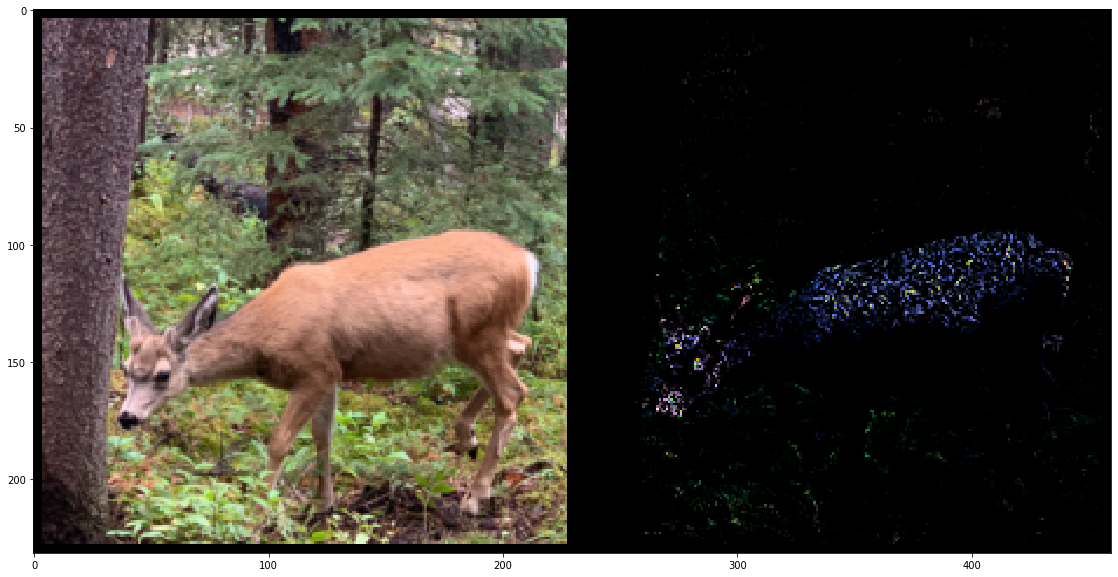

In [55]:
print('Predicted:', predicted_label, '(', prediction_score.squeeze().item(), ')')

integrated_gradients = IntegratedGradients(model)
attributions_ig, delta = integrated_gradients.attribute(input, target=pred_label_idx)
visualize(attributions_ig)

Computes attributions using Integrated Gradients and smoothens them across multiple images generated by noise tunnel using 

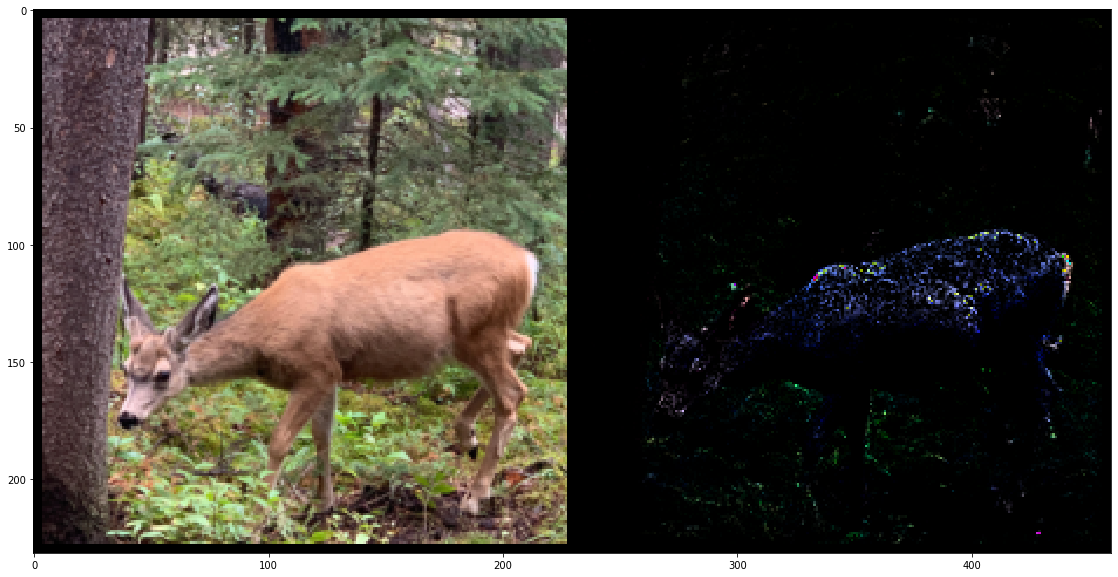

In [13]:
noise_tunnel = NoiseTunnel(integrated_gradients)

attributions_ig_nt, delta = noise_tunnel.attribute(input, n_samples=3, target=pred_label_idx)
visualize(attributions_ig_nt)


Computes GradientShap using a simple reference distribution of two images.

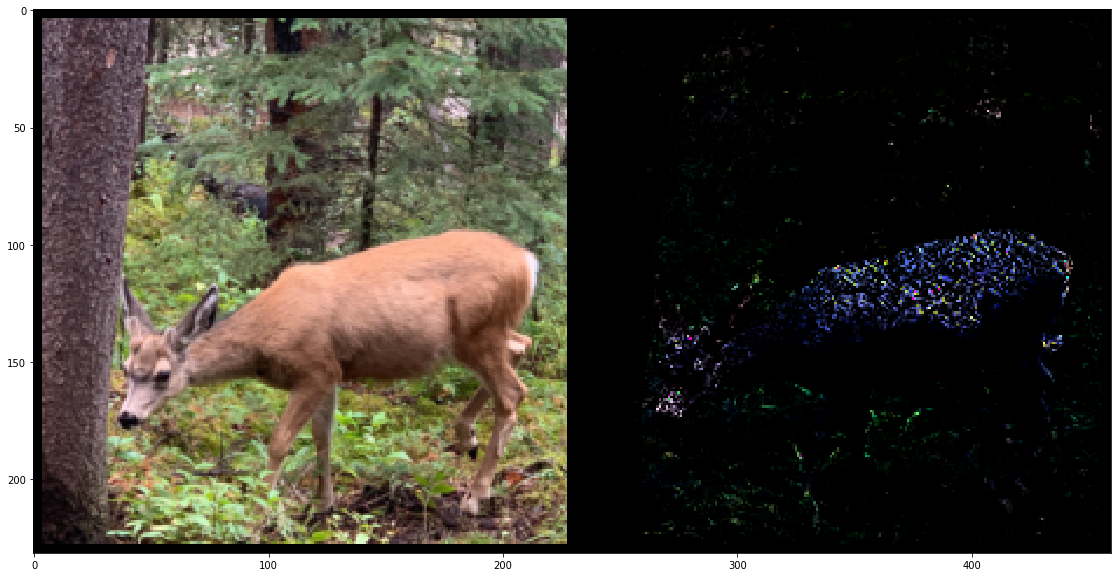

In [18]:
torch.manual_seed(123)
np.random.seed(123)

gradient_shap = GradientShap(model)

# Defining baseline distribution of images
rand_img_dist = torch.cat([input * 0, random_image(input, 0, 255)])

attributions_gs, delta = gradient_shap.attribute(input,
                                                 n_samples=15,
                                                 stdevs=0.0001,
                                                 baselines=rand_img_dist,
                                                 target=pred_label_idx)
visualize(attributions_gs)